In [1]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"


  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /tmp/pip-req-build-nc2n45t_
All libraries are successfully installed!


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [4]:
!ls -ltr
!hostname -i

total 4
drwxr-xr-x 1 root root 4096 Jun 28 13:38 sample_data
172.28.0.12


In [5]:
!git clone https://github.com/amitkml/ERA-V1

Cloning into 'ERA-V1'...
remote: Enumerating objects: 218, done.
remote: Counting objects: 100% (192/192), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 218 (delta 64), reused 155 (delta 31), pack-reused 26
Receiving objects: 100% (218/218), 88.79 MiB | 6.99 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Updating files: 100% (112/112), done.


In [6]:
cd "/content/ERA-V1/Session9"

/content/ERA-V1/Session9


# Loading UD modules

In [7]:
import pandas as pd
import numpy as np

import torch
import data_utils as dutils
import model_utils as mutils
import plot_utils as putils
import regularization
import model_cifar as mod_cifar
# import model_cifar_gnorm as model_gcifar
# import model_cifar_lnorm as model_cifar_lnorm
import matplotlib.pyplot as plt
import seaborn as sns
import models as mod
# import albumentations as A
from torchvision import datasets, transforms
import os

# Check GPU avaiability

In [8]:
device = dutils.get_device()

CUDA Available? True
Device is cuda:0


In [9]:
device.type

'cuda'

In [10]:
cuda = torch.cuda.is_available()

In [11]:
cuda

True

# CIFAR10 Basics

In [12]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

SEED = 1
batch_size=64

# CUDA?
if device.type == 'cuda':
    torch.cuda.manual_seed(SEED)
else:
    torch.manual_seed(SEED)

# Load CIFAR10 dataset

In [13]:
os.getcwd()

'/content/ERA-V1/Session9'

In [14]:
# path = os.getcwd()
# path
# # Load the CIFAR-10 training dataset
# train_dataset = datasets.CIFAR10(root=path, train=True, download=True)

# # Calculate the mean value of the dataset
# mean_value_of_dataset = train_dataset.data.mean(axis=(0, 1, 2)) / 255

# # Print the mean value
# print("Mean value of the dataset:", mean_value_of_dataset)

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import albumentations as A
from albumentations.pytorch import ToTensorV2
# from Albumentationtransform import AlbumentationTransforms
from albumentations.pytorch import ToTensorV2


In [16]:
from torchvision import transforms
import albumentations as A
import albumentations.pytorch as AP
import random
import numpy as np

class AlbumentationTransforms:
  """
  Helper class to create test and train transforms using Albumentations
  """
  def __init__(self, transforms_list=[]):
    transforms_list.append(AP.ToTensorV2())

    self.transforms = A.Compose(transforms_list)


  def __call__(self, img):
    img = np.array(img)
    #print(img)
    return self.transforms(image=img)['image']


In [17]:
channel_means = (0.5, 0.5, 0.5)
channel_stdevs = (0.5, 0.5, 0.5)
train_transform = AlbumentationTransforms([
                                       A.Rotate((-28.0, 28.0)),
                                       A.HorizontalFlip(),
                                       A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                       A.Cutout(num_holes=3, max_h_size=4,max_w_size = 4,p=0.)
                                       ])
# Test Phase transformations
test_transform = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])

In [18]:
# load CIFAR10 dataset
# train_loader, test_loader = dutils.get_dataloader(batch_size=batch_size, num_workers=4, cuda = True,path = path )

# Define the Albumentations transformations
# # Define augmentation transformations
# transform = A.Compose([
#     A.HorizontalFlip(),
#     A.ShiftScaleRotate(),
#     A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, fill_value=mean_value_of_dataset, mask_fill_value=None),
#     ToTensorV2(),
# ])

# Create train and test datasets
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)

# Create data loaders
batch_size = batch_size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)


100%|██████████| 170498071/170498071 [00:03<00:00, 48811816.63it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Data mage Visualization

In [19]:
# plot_dataset_images_cifar(device, classes, train_loader)

# Model with BN - From github

### Model structure

In [20]:
# class Net(nn.Module):
#     def __init__(self, dropout_value = 0.0015, num_classes=10):
#         super(Net, self).__init__()

#         # Convolution Block 1
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
#         self.bn1 = nn.BatchNorm2d(16)
#         self.dropout = nn.Dropout(dropout_value)
#         # Convolution Block 2
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
#         self.bn2 = nn.BatchNorm2d(32)

#         # Convolution Block 3
#         self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
#         self.bn3 = nn.BatchNorm2d(64)

#         # Depthwise Separable Convolution Block
#         self.depthwise_conv = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, groups=64)
#         self.pointwise_conv = nn.Conv2d(64, 128, kernel_size=1, stride=1)
#         self.bn4 = nn.BatchNorm2d(128)

#         # Dilated Convolution Block
#         self.dilated_conv = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=2, dilation=2)
#         self.bn5 = nn.BatchNorm2d(128)

#         # Global Average Pooling
#         self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

#         # Fully Connected Layer

#         self.fc1 = nn.Linear(128, 32)
#         self.fc = nn.Linear(32, num_classes)

#     def forward(self, x):
#         # Convolution Block 1
#         x = F.relu(self.dropout(self.bn1(self.conv1(x))))

#         # Convolution Block 2
#         x = F.relu(self.dropout(self.bn2(self.conv2(x))))

#         # Convolution Block 3
#         x = F.relu(self.dropout(self.bn3(self.conv3(x))))

#         # Depthwise Separable Convolution Block
#         x = F.relu(self.dropout(self.bn4(self.pointwise_conv(self.depthwise_conv(x)))))

#         # Dilated Convolution Block
#         x = F.relu(self.dropout(self.bn5(self.dilated_conv(x))))

#         # Global Average Pooling
#         x = self.global_avg_pool(x)
#         x = x.view(x.size(0), -1)

#         # Fully Connected Layer
#         x = self.fc(self.fc1(x))

#         return F.log_softmax(x, dim=-1)



In [21]:
# model = mod.ResNet18()
# model = Net() ##
model = mod_cifar.model()

In [22]:
mutils.model_summary(model, device, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
           Dropout-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
       BatchNorm2d-5           [-1, 32, 16, 16]              64
           Dropout-6           [-1, 32, 16, 16]               0
            Conv2d-7             [-1, 64, 8, 8]          18,496
       BatchNorm2d-8             [-1, 64, 8, 8]             128
           Dropout-9             [-1, 64, 8, 8]               0
           Conv2d-10             [-1, 64, 8, 8]             640
           Conv2d-11            [-1, 128, 8, 8]           8,320
      BatchNorm2d-12            [-1, 128, 8, 8]             256
          Dropout-13            [-1, 128, 8, 8]               0
           Conv2d-14            [-1, 12

In [23]:
# Create CIFAR10 network
# model = model_cifar.Net(dropout_value = 0.05)
# mutils.model_summary(model, device, input_size=(3, 32, 32))

## Build and train model

In [24]:
test_loader

In [25]:
# build and train the model
model_name = "Model CIFAR10"
EPOCHS = 40
model =  model.to(device) # use GPU

# using L1 and L2 regularization
train_acc, train_losses, test_acc, test_losses = mutils.build_model(model,
                                                            device,
                                                            trainloader=train_loader,
                                                            testloader=test_loader,
                                                            epochs=EPOCHS,
                                                            L1_loss_flag=True,
                                                            L2_penalty_val=0.001)

EPOCH: 0


Loss=1.677807 Batch_id=781 Accuracy=39.58: 100%|██████████| 782/782 [00:27<00:00, 28.31it/s]



Test set: Average loss: 1.452081, Accuracy: 4855/10000 (48.55%)

EPOCH: 1


Loss=1.373978 Batch_id=781 Accuracy=51.99: 100%|██████████| 782/782 [00:27<00:00, 28.48it/s]



Test set: Average loss: 1.433155, Accuracy: 5233/10000 (52.33%)

EPOCH: 2


Loss=1.257984 Batch_id=781 Accuracy=56.80: 100%|██████████| 782/782 [00:30<00:00, 25.30it/s]



Test set: Average loss: 1.275765, Accuracy: 5669/10000 (56.69%)

EPOCH: 3


Loss=1.188131 Batch_id=781 Accuracy=59.95: 100%|██████████| 782/782 [00:26<00:00, 29.11it/s]



Test set: Average loss: 1.316092, Accuracy: 5365/10000 (53.65%)

EPOCH: 4


Loss=1.142434 Batch_id=781 Accuracy=61.66: 100%|██████████| 782/782 [00:27<00:00, 28.53it/s]



Test set: Average loss: 1.389805, Accuracy: 5348/10000 (53.48%)

EPOCH: 5


Loss=1.119128 Batch_id=781 Accuracy=62.69: 100%|██████████| 782/782 [00:27<00:00, 28.52it/s]



Test set: Average loss: 1.035552, Accuracy: 6359/10000 (63.59%)

EPOCH: 6


Loss=1.094044 Batch_id=781 Accuracy=63.63: 100%|██████████| 782/782 [00:27<00:00, 28.67it/s]



Test set: Average loss: 1.140600, Accuracy: 6019/10000 (60.19%)

EPOCH: 7


Loss=1.099709 Batch_id=781 Accuracy=63.23: 100%|██████████| 782/782 [00:27<00:00, 28.12it/s]



Test set: Average loss: 1.086906, Accuracy: 6189/10000 (61.89%)

EPOCH: 8


Loss=0.837624 Batch_id=781 Accuracy=72.60: 100%|██████████| 782/782 [00:27<00:00, 28.35it/s]



Test set: Average loss: 0.656834, Accuracy: 7772/10000 (77.72%)

EPOCH: 9


Loss=0.765967 Batch_id=781 Accuracy=75.07: 100%|██████████| 782/782 [00:27<00:00, 28.56it/s]



Test set: Average loss: 0.629960, Accuracy: 7852/10000 (78.52%)

EPOCH: 10


Loss=0.738866 Batch_id=781 Accuracy=75.96: 100%|██████████| 782/782 [00:29<00:00, 26.96it/s]



Test set: Average loss: 0.611220, Accuracy: 7923/10000 (79.23%)

EPOCH: 11


Loss=0.723745 Batch_id=781 Accuracy=76.34: 100%|██████████| 782/782 [00:27<00:00, 28.51it/s]



Test set: Average loss: 0.618842, Accuracy: 7927/10000 (79.27%)

EPOCH: 12


Loss=0.714022 Batch_id=781 Accuracy=76.67: 100%|██████████| 782/782 [00:27<00:00, 28.38it/s]



Test set: Average loss: 0.627567, Accuracy: 7856/10000 (78.56%)

EPOCH: 13


Loss=0.708053 Batch_id=781 Accuracy=76.95: 100%|██████████| 782/782 [00:27<00:00, 28.50it/s]



Test set: Average loss: 0.624698, Accuracy: 7873/10000 (78.73%)

EPOCH: 14


Loss=0.702532 Batch_id=781 Accuracy=77.16: 100%|██████████| 782/782 [00:27<00:00, 28.14it/s]



Test set: Average loss: 0.663345, Accuracy: 7744/10000 (77.44%)

EPOCH: 15


Loss=0.695897 Batch_id=781 Accuracy=77.24: 100%|██████████| 782/782 [00:27<00:00, 28.29it/s]



Test set: Average loss: 0.635905, Accuracy: 7810/10000 (78.10%)

EPOCH: 16


Loss=0.619747 Batch_id=781 Accuracy=80.09: 100%|██████████| 782/782 [00:27<00:00, 28.30it/s]



Test set: Average loss: 0.522761, Accuracy: 8256/10000 (82.56%)

EPOCH: 17


Loss=0.593796 Batch_id=781 Accuracy=80.91: 100%|██████████| 782/782 [00:27<00:00, 28.54it/s]



Test set: Average loss: 0.513735, Accuracy: 8261/10000 (82.61%)

EPOCH: 18


Loss=0.579228 Batch_id=781 Accuracy=81.44: 100%|██████████| 782/782 [00:27<00:00, 28.10it/s]



Test set: Average loss: 0.511299, Accuracy: 8284/10000 (82.84%)

EPOCH: 19


Loss=0.575770 Batch_id=781 Accuracy=81.54: 100%|██████████| 782/782 [00:27<00:00, 28.90it/s]



Test set: Average loss: 0.506169, Accuracy: 8320/10000 (83.20%)

EPOCH: 20


Loss=0.562197 Batch_id=781 Accuracy=81.98: 100%|██████████| 782/782 [00:27<00:00, 28.66it/s]



Test set: Average loss: 0.501643, Accuracy: 8332/10000 (83.32%)

EPOCH: 21


Loss=0.559835 Batch_id=781 Accuracy=82.17: 100%|██████████| 782/782 [00:28<00:00, 27.04it/s]



Test set: Average loss: 0.498730, Accuracy: 8303/10000 (83.03%)

EPOCH: 22


Loss=0.556779 Batch_id=781 Accuracy=82.27: 100%|██████████| 782/782 [00:27<00:00, 28.91it/s]



Test set: Average loss: 0.496612, Accuracy: 8346/10000 (83.46%)

EPOCH: 23


Loss=0.548411 Batch_id=781 Accuracy=82.53: 100%|██████████| 782/782 [00:27<00:00, 28.78it/s]



Test set: Average loss: 0.496720, Accuracy: 8341/10000 (83.41%)

EPOCH: 24


Loss=0.536852 Batch_id=781 Accuracy=82.74: 100%|██████████| 782/782 [00:27<00:00, 28.36it/s]



Test set: Average loss: 0.488951, Accuracy: 8367/10000 (83.67%)

EPOCH: 25


Loss=0.533458 Batch_id=781 Accuracy=83.08: 100%|██████████| 782/782 [00:27<00:00, 28.78it/s]



Test set: Average loss: 0.485890, Accuracy: 8377/10000 (83.77%)

EPOCH: 26


Loss=0.533682 Batch_id=781 Accuracy=83.06: 100%|██████████| 782/782 [00:27<00:00, 28.86it/s]



Test set: Average loss: 0.484943, Accuracy: 8372/10000 (83.72%)

EPOCH: 27


Loss=0.533032 Batch_id=781 Accuracy=83.03: 100%|██████████| 782/782 [00:27<00:00, 28.93it/s]



Test set: Average loss: 0.484291, Accuracy: 8376/10000 (83.76%)

EPOCH: 28


Loss=0.528383 Batch_id=781 Accuracy=83.19: 100%|██████████| 782/782 [00:27<00:00, 28.64it/s]



Test set: Average loss: 0.482283, Accuracy: 8395/10000 (83.95%)

EPOCH: 29


Loss=0.531875 Batch_id=781 Accuracy=83.17: 100%|██████████| 782/782 [00:26<00:00, 29.37it/s]



Test set: Average loss: 0.482447, Accuracy: 8376/10000 (83.76%)

EPOCH: 30


Loss=0.528366 Batch_id=781 Accuracy=83.16: 100%|██████████| 782/782 [00:27<00:00, 28.89it/s]



Test set: Average loss: 0.484322, Accuracy: 8386/10000 (83.86%)

EPOCH: 31


Loss=0.526963 Batch_id=781 Accuracy=83.21: 100%|██████████| 782/782 [00:27<00:00, 28.88it/s]



Test set: Average loss: 0.484086, Accuracy: 8385/10000 (83.85%)

EPOCH: 32


Loss=0.527970 Batch_id=781 Accuracy=83.25: 100%|██████████| 782/782 [00:28<00:00, 27.49it/s]



Test set: Average loss: 0.481478, Accuracy: 8375/10000 (83.75%)

EPOCH: 33


Loss=0.528955 Batch_id=781 Accuracy=83.11: 100%|██████████| 782/782 [00:27<00:00, 28.02it/s]



Test set: Average loss: 0.482359, Accuracy: 8373/10000 (83.73%)

EPOCH: 34


Loss=0.525023 Batch_id=781 Accuracy=83.31: 100%|██████████| 782/782 [00:27<00:00, 28.44it/s]



Test set: Average loss: 0.485650, Accuracy: 8344/10000 (83.44%)

EPOCH: 35


Loss=0.527676 Batch_id=781 Accuracy=83.22: 100%|██████████| 782/782 [00:27<00:00, 28.62it/s]



Test set: Average loss: 0.483400, Accuracy: 8373/10000 (83.73%)

EPOCH: 36


Loss=0.523739 Batch_id=781 Accuracy=83.36: 100%|██████████| 782/782 [00:27<00:00, 27.94it/s]



Test set: Average loss: 0.482905, Accuracy: 8387/10000 (83.87%)

EPOCH: 37


Loss=0.522509 Batch_id=781 Accuracy=83.44: 100%|██████████| 782/782 [00:27<00:00, 28.46it/s]



Test set: Average loss: 0.478488, Accuracy: 8397/10000 (83.97%)

EPOCH: 38


Loss=0.530883 Batch_id=781 Accuracy=83.15: 100%|██████████| 782/782 [00:27<00:00, 28.32it/s]



Test set: Average loss: 0.488999, Accuracy: 8356/10000 (83.56%)

EPOCH: 39


Loss=0.526588 Batch_id=781 Accuracy=83.13: 100%|██████████| 782/782 [00:27<00:00, 28.94it/s]



Test set: Average loss: 0.481584, Accuracy: 8375/10000 (83.75%)



## Test Accuracy

In [26]:
mutils.get_test_accuracy(model, device, test_loader)


Accuracy of the network on the 10000 test images: 83.75%



### Class level Accuracy

In [27]:
mutils.class_based_accuracy(model, device, classes, test_loader)

Accuracy of plane : 91 %
Accuracy of   car : 90 %
Accuracy of  bird : 73 %
Accuracy of   cat : 68 %
Accuracy of  deer : 80 %
Accuracy of   dog : 72 %
Accuracy of  frog : 89 %
Accuracy of horse : 89 %
Accuracy of  ship : 91 %
Accuracy of truck : 92 %


## Visualization


Ploting Accuracy and Loss history: Model CIFAR10



TypeError: ignored

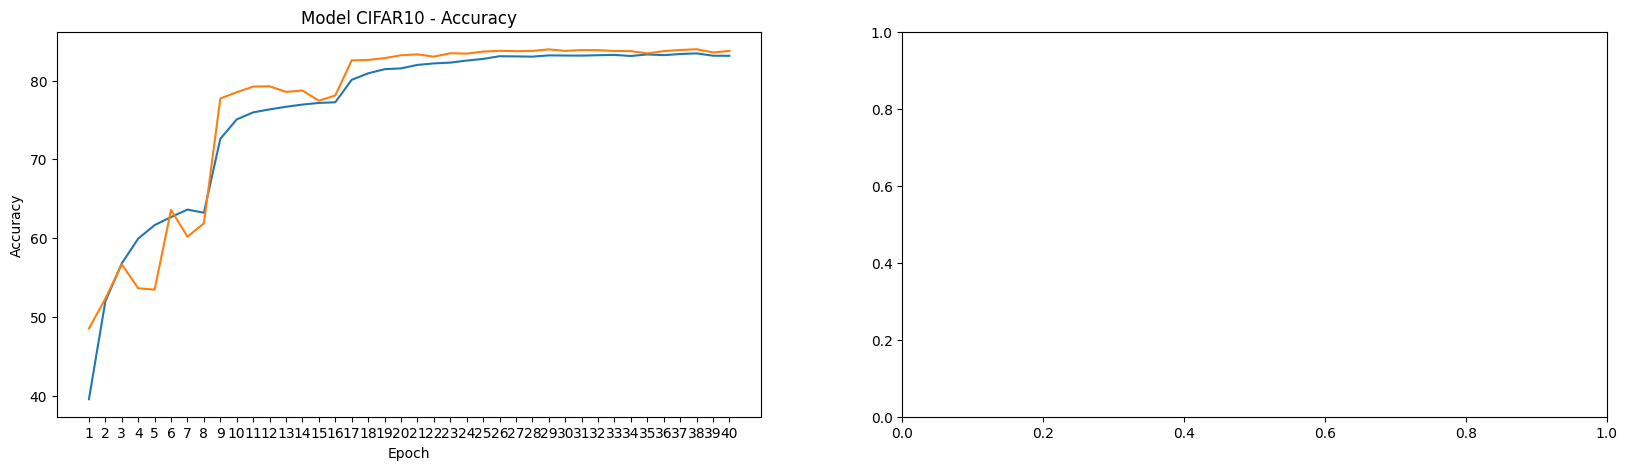

In [28]:
print("\nPloting Accuracy and Loss history: {}\n".format(model_name))
putils.plot_model_history(model_name,
                   train_acc,test_acc,
                   train_losses,test_losses,
                   save_filename = "model_history")

## Misclassified images


Ploting misclassified images: Model CIFAR10



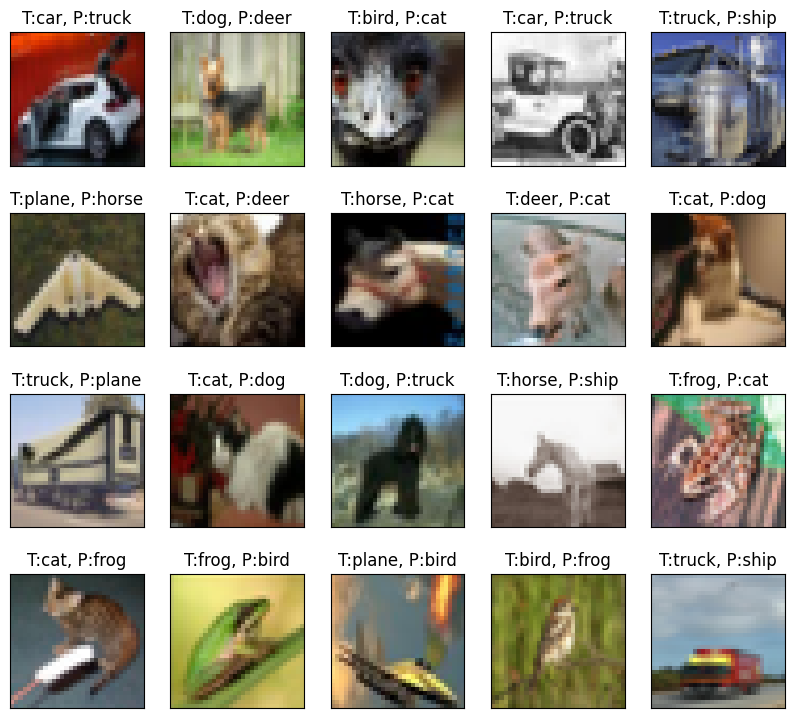

In [29]:
print ("\nPloting misclassified images: {}\n".format(model_name))

putils.miss_classification('Test',model,
                          device,
                          classes,
                          testloader=test_loader,
                          num_of_images = 20,
                          save_filename="model_misclassified")